In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import matplotlib.pyplot as plt

In [2]:
import crypten
crypten.init()
torch.set_num_threads(1)
crypten_output = torch.ones((0))
true_output = torch.ones((0))
pytorch_output = torch.ones((0))

In [3]:
hr_start, hr_end = 660, 720
n_servers = 3
epsilon = 1e-3
test_fraction = 1/20
valid_fraction = 1/10
n_epochs = 200
n_lat_grid_lines = 100
n_long_grid_lines = 100
optimizer = "SGD"

In [4]:
from torch import Tensor
from torch.nn import Linear

In [5]:
import datetime
#Put the file location
df = pd.read_csv('../GNN//GNN-to_share/GNN-to_share/20-10_all.csv')

#type casting
df.pm1_0 = df.pm1_0.astype(float)
df.pm2_5 = df.pm2_5.astype(float)
df.pm10 = df.pm10.astype(float)
df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
df.long= round(round(5*df.long.astype(float),2)/5.0,3)
df.pressure = df.pressure.astype(float)
df.temperature = df.temperature.astype(float)
df.humidity = df.humidity.astype(float)
df.dateTime = pd.to_datetime(df.dateTime)

print(len(df))
# Ensuring Delhi region and removing outliers from data
df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
df = df[(df.humidity<=60)&(df.humidity>=7)]
print(len(df))

97358
86892


In [6]:
# rounding @15min
df.dateTime = df.dateTime.dt.round('15min')

# only PM10
dfHour = df[(df['dateTime'].dt.day == 20)][['dateTime','lat','long','pm1_0']]

# TODO: Add buffer and consider train-data for range
lat_range = {'min': dfHour.lat.min(), 'max': dfHour.lat.max()}
long_range = {'min': dfHour.long.min(), 'max': dfHour.long.max()}

dfHour['lat_grid'] = dfHour.apply(lambda row: int(n_lat_grid_lines*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
dfHour['long_grid'] = dfHour.apply(lambda row: int(n_long_grid_lines*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
dfHour['lat_grid'] = dfHour['lat_grid'].astype(float).astype(int)
dfHour['long_grid'] = dfHour['long_grid'].astype(float).astype(int)
del dfHour['lat']
del dfHour['long']

# TODO: use time as a feature as well
# converting time to minutes and selecting a one hour slot
dfHour.dateTime = dfHour.dateTime.dt.hour*60 + dfHour.dateTime.dt.minute
dfHour = dfHour[(dfHour.dateTime>=hr_start) & (dfHour.dateTime<=hr_end)] 

del dfHour['dateTime']

In [7]:
dfHour.long_grid.value_counts()

97    1491
63     316
47     180
93     173
95     152
      ... 
31       4
26       4
38       3
33       3
35       2
Name: long_grid, Length: 65, dtype: int64

In [8]:
dfHour.lat_grid.value_counts()

2     1027
1      396
41     299
39     169
43     139
      ... 
56       8
64       8
70       8
83       7
84       5
Name: lat_grid, Length: 79, dtype: int64

In [9]:
dfHour['server'] = np.random.randint(0, 3, len(dfHour))
dfHour = dfHour.reset_index(drop=True)

grid = {}
count = 0
count2 = 0
for i,row in dfHour.iterrows():
#     print(f"{int(row.lat_grid)} {int(row.long_grid)}")
    if(not f"{int(row.lat_grid)} {int(row.long_grid)}" in grid):
        grid[f"{int(row.lat_grid)} {int(row.long_grid)}"] = count
        count += 1
        count2 += 1
#     if(not f"{int(row.lat_grid + 1)} {int(row.long_grid)}" in grid):
#         grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"] = count
#         count += 1
#     if(not f"{int(row.lat_grid)} {int(row.long_grid + 1)}" in grid):
#         grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"] = count
#         count += 1
#     if(not f"{int(row.lat_grid - 1)} {int(row.long_grid)}" in grid):
#         grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"] = count
#         count += 1
#     if(not f"{int(row.lat_grid)} {int(row.long_grid - 1)}" in grid):
#         grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"] = count
#         count += 1

print(count)
print(count2)

adj = np.zeros((count, count))
aqi = np.zeros((n_servers, count))
mask = np.zeros((n_servers, count))

for i,row in dfHour.iterrows():
    
    mask_ser_grid = mask[int(row.server)][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]]
    aqi[int(row.server)][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] *= mask_ser_grid/(mask_ser_grid+1)
    aqi[int(row.server)][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] += row.pm1_0/(mask_ser_grid+1)
    mask[int(row.server)][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] += 1
    
    if(f"{int(row.lat_grid + 1)} {int(row.long_grid)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]] = 1
    if(f"{int(row.lat_grid)} {int(row.long_grid + 1)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]] = 1
    if(f"{int(row.lat_grid - 1)} {int(row.long_grid)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]] = 1
    if(f"{int(row.lat_grid)} {int(row.long_grid - 1)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]] = 1
    
    if(f"{int(row.lat_grid + 1)} {int(row.long_grid)}" in grid):
        adj[grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
    if(f"{int(row.lat_grid)} {int(row.long_grid + 1)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
    if(f"{int(row.lat_grid - 1)} {int(row.long_grid)}" in grid):
        adj[grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
    if(f"{int(row.lat_grid)} {int(row.long_grid - 1)}" in grid):
        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
    
#     adj[grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]] = 1
#     adj[grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]] = 1
#     adj[grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]] = 1
#     adj[grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]] = 1
    adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1

208
208


In [10]:
mask = torch.tensor(mask)
adj = torch.tensor(adj)
aqi = torch.tensor(aqi)

In [11]:
test_indices = random.sample(range(aqi.shape[1]), int(aqi.shape[1] * test_fraction))
aqi_train = aqi * 1
aqi_train[:, test_indices] = 0

mask_train = mask * 1
mask_train[:, test_indices] = 0

adj_train = adj.clone().detach()
adj_train[:, test_indices] = 0

In [12]:
def train_valid_split(train_data, rank):
    mult = torch.ones(train_data['aqi'].shape)
    mult2 = torch.ones(train_data['mask'].shape)
    mult3 = torch.ones(train_data['adj'].shape)
    
    if rank == 0:
        valid_indices = random.sample(range(train_data['aqi'].shape[0]), int(train_data['aqi'].shape[0] * valid_fraction))

        mult[valid_indices, :] = 0

        mult2[valid_indices] = 0
        
        mult3[:, valid_indices] = 0
    
    mult = crypten.cryptensor(mult, src = 0) 
    
    aqi_train_valid = train_data['aqi'] * mult
    
    mult2 = crypten.cryptensor(mult2, src=0) 
    
    mask_train_valid = train_data['mask'] * mult2
    mask_train_valid = mask_train_valid > 0.1
#     crypten.print(train_data['mask'].sum().get_plain_text())
#     crypten.print(mask_train_valid.sum().get_plain_text())
    
    mult3 = crypten.cryptensor(mult3, src=0).get_plain_text() 
    new_adj = train_data['adj'].clone().detach()
    new_adj = new_adj * mult3
        
    train_valid_data = {
        'adj': new_adj,
        'aqi': aqi_train_valid,
        'mask': mask_train_valid
    }
    return train_valid_data

In [13]:
class GCNConv(crypten.nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GCNConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        temp_weight = torch.FloatTensor(in_features, out_features)
        if bias:
            temp_bias = torch.FloatTensor(out_features)
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(temp_weight, temp_bias)

    def reset_parameters(self, temp_weight, temp_bias):
        stdv = 1. / math.sqrt(temp_weight.size(1))
        
        temp_weight.data.uniform_(-stdv, stdv)
        self.register_parameter('weight', temp_weight)
        
        if temp_bias is not None:
            temp_bias.data.uniform_(-stdv, stdv)
            self.register_parameter('bias', temp_bias)
            

    def forward(self, input, adj):
        #  Support becomes N X output_features
        support = input.matmul(self.weight)
        temp = crypten.cryptensor(adj)
        print(type(temp))
        D = (1 + temp.sum(dim=1).unsqueeze(-1)).reciprocal()
        #  Output is N X output_features
        output = D * temp.matmul(support)
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' ('                + str(self.in_features) + ' -> '                + str(self.out_features) + ')'


In [14]:
# module_try = GCNConv(2,8)   
weight = torch.FloatTensor(2, 8)
temp = crypten.cryptensor(weight)
print(weight)

tensor([[1.5766e-19, 1.0256e-08, 6.4456e-10, 3.0271e+12, 6.7742e-10, 6.7512e-07,
         1.0373e-08, 1.2540e+16],
        [2.1707e-18, 7.0952e+22, 1.7748e+28, 1.8176e+31, 7.2708e+31, 5.0778e+31,
         3.2608e-12, 1.7728e+28]])


In [15]:
# TODO/ASK: too many parameters
class Net(crypten.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1Mean = GCNConv(2,8)        
        self.conv2Mean = GCNConv(8,8)
        
        self.lin3 = crypten.nn.Linear(8, 1)
    
    def lrelu(self, x, alpha):
        temp1 = ((x < 0) * alpha) + (x > 0)
        return temp1 * x
    
    def forward(self, data):
        x, adj = crypten.cat([data['aqi'],data['mask'].unsqueeze(-1)],1), data['adj']
        x = self.lrelu(self.conv1Mean(x, adj), 0.1)
#         crypten.print(x.get_plain_text())
        x = self.lrelu(self.conv2Mean(x, adj), 0.1)
#         crypten.print(x.get_plain_text())
        x = self.lin3(x)
#         crypten.print(x.get_plain_text())
        return x.squeeze()

In [16]:
loss_array = []

In [17]:
def train(net, data_train, combined_y_enc, rank):
    global loss_array

    net.train() # Change to training mode
    net.encrypt()
    loss = crypten.nn.MSELoss() # Choose loss functions

    
    crypten_optimizer = crypten.optim.SGD(net.parameters(), lr = 0.0001)
    
    # Set parameters: learning rate, num_epochs
#     learning_rate = 0.001
    num_epochs = n_epochs
      
    
    # Train the model: SGD on encrypted data
    for i in range(num_epochs):
        
        # set gradients to zero
        net.zero_grad()
        
        data_valid = train_valid_split(data_train, rank=rank)  
        
        # forward pass
        output = net(data_valid)
        print(type(data_valid))
#         crypten.print(data_train['mask'])
        loss_value = loss(output * data_train['mask'], combined_y_enc * data_train['mask'])
        
        # perform backward pass
        loss_value.backward()

        # update parameters
        crypten_optimizer.step()
            
        # examine the loss after each epoch
        l_t = loss_value.get_plain_text()
        loss_array.append(l_t)
        crypten.print("Epoch: {0:d} Loss: {1:.4f}".format(i, l_t))

In [20]:
import crypten.mpc as mpc
import crypten.communicator as comm
from crypten.communicator.communicator import _logging
# from crypten.common.approximations import ConfigManager
from crypten.config import cfg
num_parties = n_servers
torch.manual_seed(42)
model = Net()

In [34]:
# Parties' data
x = aqi_train[rank].unsqueeze(-1)
train_mask = mask_train[rank].unsqueeze(-1)
y = aqi_train[rank]

# Combined data
combined_mask_enc = crypten.cryptensor(train_mask, src = 0)
combined_x_enc = crypten.cryptensor(x, src = 0) * combined_mask_enc
combined_y_enc = crypten.cryptensor(y, src = 0) * combined_mask_enc.t()
# Take or to get final mask
combined_mask_enc = (combined_mask_enc.sum(dim=1, keepdim=True) > 0).squeeze()

train_data = {
    'adj': adj_matrix,
    'aqi': combined_x_enc,
    'mask': combined_mask_enc
}
crypten.print(combined_mask_enc.sum().get_plain_text())
#         crypten.print(combined_y_enc.get_plain_text())


# net = model
# net.encrypt()
crypten.print(train_data)
# train(net, train_data, combined_y_enc, rank)


In [32]:
@mpc.run_multiprocess(world_size=num_parties)
def run_encrypted_training():
    global model, loss_array
    # Get rank of current process
    rank = comm.get().get_rank()
    
    with ConfigManager("reciprocal_nr_iters", 12):

        # Parties' data
        x = aqi_train[rank].unsqueeze(-1)
        train_mask = mask_train[rank].unsqueeze(-1)
        y = aqi_train[rank]

        # Combined data
        combined_mask_enc = crypten.cryptensor(train_mask, src = 0)
        combined_x_enc = crypten.cryptensor(x, src = 0) * combined_mask_enc
        combined_y_enc = crypten.cryptensor(y, src = 0) * combined_mask_enc.t()

        adj_matrix = adj_train

        # Get features and adjacency matrix
        for i in range(1, num_parties):       
            x_enc = crypten.cryptensor(x, src = i)
            y_enc = crypten.cryptensor(y, src = i)
            mask_enc = crypten.cryptensor(train_mask, src = i)

            combined_x_enc = combined_x_enc + x_enc * mask_enc
            combined_y_enc = combined_y_enc + y_enc * mask_enc.t()
            combined_mask_enc = crypten.cat([combined_mask_enc, mask_enc], dim=1)

        # Add epsilon to prevent 0/0
        normalise = (combined_mask_enc.sum(dim=1, keepdim=True) + epsilon) / 10

        # Combined x encrypted -> average of all
        combined_x_enc = combined_x_enc / 10
        combined_x_enc = combined_x_enc / normalise

        combined_y_enc = combined_y_enc / 10 
        combined_y_enc = (combined_y_enc / normalise.t()).squeeze()

        # Take or to get final mask
        combined_mask_enc = (combined_mask_enc.sum(dim=1, keepdim=True) > 0).squeeze()

        train_data = {
            'adj': adj_matrix,
            'aqi': combined_x_enc,
            'mask': combined_mask_enc
        }

    #     crypten.print(torch.max(normalise.get_plain_text()))
        crypten.print(combined_mask_enc.sum().get_plain_text())
#         crypten.print(combined_y_enc.get_plain_text())


        net = model
        net.encrypt()
        train(net, train_data, combined_y_enc, rank)
        

In [33]:
run_encrypted_training()

In [ ]:
loss_array

In [ ]:
for i in model.named_parameters():
    print(i)

In [218]:
aqi_mean = (aqi*mask).sum(axis=0)/(mask.sum(axis=0) + epsilon)
mask_mean = (mask).sum(axis=0)
mask_mean[mask_mean > 0] = 1
mask_mean_train = mask_mean * 1
mask_mean_train[test_indices] = 0
aqi_mean_train = aqi_mean * 1
aqi_mean_train[test_indices] = 0
train_data = {
    'adj': adj_train.float(),
    'aqi': aqi_mean_train.view(-1,1).float(),
    'mask': mask_mean_train.float()
}
def eval(output = output, aqi_mean=aqi_mean, test_indices=test_indices):
    test_output = (torch.reshape(output,(-1,)) * mask_mean)[test_indices]
    true_test_output = aqi_mean[test_indices]
    test_loss = F.mse_loss(test_output, true_test_output)
    test_loss *= len(train_data['mask'])/torch.sum(train_data['mask'])
    print(test_output)
    print(true_test_output)
    return test_output, true_test_output, test_loss.item()

# # In[13]:

In [219]:
crypten_output_temp, true_output_temp, l = eval()
print(l)

tensor([20.7303, 25.9158, 28.1599,  0.2406, 41.8291, 21.6307, 22.6942, 16.0909,
        30.4941, 31.5359], dtype=torch.float64)
tensor([27.5945, 31.9206, 33.3222, 29.6074, 40.9556, 29.2427, 30.8485, 39.3921,
        34.7666, 40.2755], dtype=torch.float64)
182.26378874995976


In [220]:
actual_test_indices = np.intersect1d(np.where(mask_mean > 0), test_indices)

In [221]:
for ind in range(len(actual_test_indices)):
    print(actual_test_indices[ind])
    print(np.where(adj[actual_test_indices[ind]]))
    print(aqi_mean[actual_test_indices[ind]])
    print(aqi_mean[np.where(adj[actual_test_indices[ind]])])

48
(array([42, 48, 56]),)
tensor(31.9206, dtype=torch.float64)
tensor([31.5360, 31.9206, 28.9065], dtype=torch.float64)
51
(array([51]),)
tensor(29.6074, dtype=torch.float64)
tensor([29.6074], dtype=torch.float64)
92
(array([90, 92, 95]),)
tensor(33.3222, dtype=torch.float64)
tensor([31.8968, 33.3222, 33.4944], dtype=torch.float64)
109
(array([108, 109, 111]),)
tensor(27.5945, dtype=torch.float64)
tensor([27.9907, 27.5945, 26.9865], dtype=torch.float64)
122
(array([119, 122, 128]),)
tensor(40.2755, dtype=torch.float64)
tensor([47.2790, 40.2755, 39.3921], dtype=torch.float64)
126
(array([125, 126, 127]),)
tensor(29.2427, dtype=torch.float64)
tensor([28.9903, 29.2427, 29.3980], dtype=torch.float64)
128
(array([122, 128, 131]),)
tensor(39.3921, dtype=torch.float64)
tensor([40.2755, 39.3921, 33.3933], dtype=torch.float64)
133
(array([127, 133, 140]),)
tensor(30.8485, dtype=torch.float64)
tensor([29.3980, 30.8485, 31.9893], dtype=torch.float64)
137
(array([135, 137, 139]),)
tensor(34.7666, 

In [222]:
# TODO: too little data and too little input features

In [223]:
# TODO: node normalization, may not be needed
class GCNConvPy(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GCNConvPy, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj, mask):
        D = 1 / (1 + adj.sum(axis=1).unsqueeze(-1))
#         D = 1 / (1 + torch.mm(adj, mask.unsqueeze(-1)))
#         print(D)
        support = torch.mm(input, self.weight)
        output = D * torch.spmm(adj, support)
#         print(output)
#         output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
# TODO/ASK: too many parameters
class NetPy(torch.nn.Module):
    def __init__(self):
        super(NetPy, self).__init__()
        self.conv1Mean = GCNConvPy(2,8)
        self.conv2Mean = GCNConvPy(8,4)
#         self.conv3Mean = GCNConv(2,2)
        self.lrelu = nn.LeakyReLU(0.1)
        self.lin3 = nn.Linear(4, 1)

    def forward(self,data):
#         x, adj = data['aqi'], data['adj']
        x, adj = torch.cat((data['aqi'],data['mask'].view(-1,1)),1), data['adj']
#         x = F.relu(self.conv1Mean(x, adj, data['mask']))
        x = self.lrelu(self.conv1Mean(x, adj, data['mask']))
        
#         x = F.relu(self.conv2Mean(x, adj, data['mask']))
        x = self.lrelu(self.conv2Mean(x, adj, data['mask']))
    
#         x = F.relu(self.conv3Mean(x, adj, data['mask']))
        x = self.lin3(x)
        return torch.squeeze(x)

torch.manual_seed(42)    
model2 = NetPy()
if (optimizer == "SGD"):
#     opt = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.01, momentum = 0.1, nesterov=True)
    opt = torch.optim.SGD(model2.parameters(), lr=0.0001) 
else:
    opt = torch.optim.Adam(model2.parameters(), lr = 0.01)

In [224]:
# aqi_mean = (aqi*mask).sum(axis=0)/(mask.sum(axis=0) + epsilon)
# mask_mean = (mask).sum(axis=0)
# mask_mean[mask_mean > 0] = 1
# train_data = {
#     'adj': adj_train,
#     'aqi': aqi_mean_train.view(-1,1),
#     'mask': torch.Tensor(mask_mean_train)
# }

# data = {
#     'adj': torch.Tensor(adj),
#     'aqi': torch.Tensor(aqi_mean).view(-1,1),
#     'mask': torch.Tensor(mask_mean)
# }

In [225]:
def train_valid_split2(train_data):
    train_nonzero_grids = list(np.array(range(train_data['mask'].shape[0]))[train_data['mask'] == 1])
    
    valid_indices = random.sample(train_nonzero_grids, int(len(train_nonzero_grids) * valid_fraction))
    
    
    
    aqi_mean_train_valid = train_data['aqi'] * 1
    aqi_mean_train_valid[valid_indices] = 0

    mask_mean_train_valid = train_data['mask'] * 1
    mask_mean_train_valid[valid_indices] = 0
    
    new_adj = train_data['adj'].clone().detach()
    new_adj[:, valid_indices] = 0
    
    train_valid_data = {
        'adj': new_adj,
        'aqi': aqi_mean_train_valid,
        'mask': mask_mean_train_valid
    }
    
    return train_valid_data, valid_indices

In [226]:
def train(opt=opt, model=model2, train_data=train_data):
    model.train()
    opt.zero_grad()
    train_valid_data, valid_indices = train_valid_split2(train_data)
    output = model(train_valid_data)
    print(output[:5])
#     print(train_data['aqi'][0:5])
    loss = F.mse_loss(torch.reshape(output,(-1,)) * train_data['mask'],torch.reshape(train_data['aqi'],(-1,)))
#     loss *= len(train_data['mask'])/torch.sum(train_data['mask'])
    loss.backward()
    opt.step()
    loss_valid = F.mse_loss(torch.reshape(output,(-1,))[valid_indices] * train_data['mask'][valid_indices],torch.reshape(train_data['aqi'],(-1,))[valid_indices])
    loss_valid *= len(train_data['mask'][valid_indices])/torch.sum(train_data['mask'])
    return loss.item(), loss_valid.item()

In [227]:
# TODO: add validation masking
from time import time
t0 = time()
loss_array = []
for i in range(n_epochs):
    loss, loss_valid = train()
    loss_array.append(loss)
    print(str(i)+":", loss, loss_valid)
print(time() - t0)

tensor([0.6194, 0.7424, 0.9559, 0.7641, 0.6383], grad_fn=<SliceBackward>)
0: 1219.18798828125 105.77371215820312
tensor([0.7854, 0.9514, 1.1584, 0.9757, 0.8103], grad_fn=<SliceBackward>)
1: 1205.9093017578125 115.36407470703125
tensor([0.9253, 1.1282, 1.4747, 1.1576, 0.9556], grad_fn=<SliceBackward>)
2: 1194.619384765625 137.3960723876953
tensor([0.8497, 1.3389, 1.6429, 1.3743, 1.1284], grad_fn=<SliceBackward>)
3: 1180.50634765625 120.47059631347656
tensor([1.2924, 1.3342, 2.0327, 1.6372, 1.3374], grad_fn=<SliceBackward>)
4: 1164.4276123046875 144.8919219970703
tensor([1.5346, 1.9034, 2.0350, 1.6087, 1.5085], grad_fn=<SliceBackward>)
5: 1143.6510009765625 118.86035919189453
tensor([1.8326, 2.2845, 2.5012, 2.3470, 0.3341], grad_fn=<SliceBackward>)
6: 1118.6055908203125 104.55078887939453
tensor([2.2009, 2.4141, 3.7013, 2.8325, 1.3565], grad_fn=<SliceBackward>)
7: 1086.5552978515625 100.99078369140625
tensor([2.6632, 3.2544, 4.3420, 3.4432, 1.6187], grad_fn=<SliceBackward>)
8: 1052.87573

94: 56.36498260498047 27.216339111328125
tensor([27.9460, 34.9331, 49.8291, 37.1158, 27.3555], grad_fn=<SliceBackward>)
95: 41.209896087646484 7.426405429840088
tensor([27.7019, 34.6265, 49.3894, 36.7897, 28.8892], grad_fn=<SliceBackward>)
96: 47.99319076538086 20.213476181030273
tensor([19.6642, 34.4244, 48.7870, 36.5748, 28.7213], grad_fn=<SliceBackward>)
97: 40.07844543457031 6.064754009246826
tensor([27.5143, 35.5084, 46.1316, 28.9864, 28.6933], grad_fn=<SliceBackward>)
98: 45.257164001464844 12.637796401977539
tensor([27.4758, 29.1781, 48.6693, 36.4871, 26.8955], grad_fn=<SliceBackward>)
99: 55.763572692871094 21.532535552978516
tensor([27.7307, 28.8097, 47.3718, 31.9301, 28.9192], grad_fn=<SliceBackward>)
100: 46.19826126098633 16.771944046020508
tensor([19.8665, 34.1711, 49.6107, 36.9546, 29.0188], grad_fn=<SliceBackward>)
101: 59.179813385009766 24.574031829833984
tensor([27.9371, 36.0562, 49.8100, 37.1025, 29.1346], grad_fn=<SliceBackward>)
102: 40.426368713378906 9.4753408432

162: 57.07843780517578 16.905193328857422
tensor([27.7603, 29.4782, 49.1483, 36.8540, 21.0356], grad_fn=<SliceBackward>)
163: 49.90898132324219 8.738123893737793
tensor([27.8577, 35.9424, 49.6375, 29.3452, 29.0500], grad_fn=<SliceBackward>)
164: 50.575111389160156 21.65534210205078
tensor([26.1669, 35.8347, 49.4878, 36.8729, 28.9634], grad_fn=<SliceBackward>)
165: 53.917930603027344 11.343740463256836
tensor([27.7250, 32.9129, 49.3978, 36.8063, 28.9115], grad_fn=<SliceBackward>)
166: 45.672115325927734 13.799849510192871
tensor([27.8077, 35.8771, 49.5462, 36.9165, 28.9977], grad_fn=<SliceBackward>)
167: 48.262142181396484 14.200675964355469
tensor([19.8049, 34.6435, 48.0799, 36.8043, 28.9102], grad_fn=<SliceBackward>)
168: 49.675331115722656 7.486685276031494
tensor([27.8531, 34.8057, 49.6271, 32.0650, 29.0451], grad_fn=<SliceBackward>)
169: 54.375648498535156 19.294553756713867
tensor([27.9071, 34.8732, 49.7238, 37.0486, 29.1014], grad_fn=<SliceBackward>)
170: 55.521400451660156 19.95

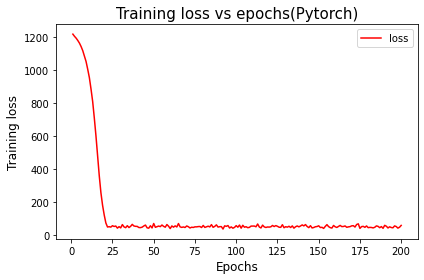

In [229]:
import matplotlib.pyplot as plt
titleFontSize = 15
labelFontSize = 12
tickFontSize = 10
legendFontSize = 10
labelStr = "size = "
yLabel = "% of test points with lower error"
xLabel = "Error %"
count_arr = [i for i in range(1, len(loss_array) + 1)]
plt.plot(count_arr, loss_array, label = "loss", color='red')
plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
plt.xlabel("Epochs", fontsize=labelFontSize)
plt.ylabel("Training loss", fontsize=labelFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.legend(prop={"size": legendFontSize})
plt.savefig("pytorch_loss.png")

In [156]:
def eval2(model=model2, train_data=train_data, aqi_mean=aqi_mean, test_indices=test_indices):
    model.eval()
    output = model(train_data)
    test_output = (torch.reshape(output,(-1,)) * mask_mean)[test_indices]
    true_test_output = aqi_mean[test_indices]
    test_loss = F.mse_loss(test_output, true_test_output)
#     test_loss = F.mse_loss(30*torch.ones(len(test_indices)) * torch.FloatTensor(mask_mean)[test_indices], true_test_output)
    test_loss *= len(train_data['mask'])/torch.sum(train_data['mask'])
    print(true_test_output)
    print(test_output)
#     print((torch.reshape(output,(-1,)) * torch.FloatTensor(mask_mean))[:20])
    return test_output, test_loss.item()

In [157]:
pytorch_output_temp, l = eval2()
print(l)

tensor([ 45.9969,  47.9840,  38.7403,  51.2372,  45.9540, 222.5555,  44.6343,
         45.4773,  81.9836,  46.9765,  64.8669,  34.7241,  54.3891],
       dtype=torch.float64)
tensor([ 33.2362,  42.4134,   0.9035,  39.1338,  38.7053, 155.5837,  40.0250,
         22.6066,  82.2646,  43.0869,  57.5541,  27.5796,  44.5388],
       dtype=torch.float64, grad_fn=<IndexBackward>)
570.6929792485591


In [158]:
crypten_output = torch.cat((crypten_output, crypten_output_temp))
pytorch_output = torch.cat((pytorch_output, pytorch_output_temp))
true_output = torch.cat((true_output, true_output_temp))

In [159]:
crypten_output

tensor([ 33.7214,   0.2390,  32.3221,  28.6523,  41.7113,  24.5185,  42.1813,
         27.9334,  35.9474,  26.4330,  28.6940,  37.7954,  28.9838,  33.8788,
         20.5909,  47.4966,  27.4407,  19.5628,  33.0279,  27.2303,  25.5486,
         21.1895,  20.6977,  38.3974,  19.8901,  31.2675,  25.9644,  24.4110,
         30.2148,  54.8356,  38.1659,  31.0375,  28.9689,  26.0812,  31.0044,
         31.4311,  43.7911,  36.1868,  16.3797,  26.2870,  34.6722,  47.2234,
         42.9798,  33.9935,  33.3003,  42.7178,   0.2395,  39.3507,  38.8931,
        158.9335,  40.2634,  22.3830,  83.6168,  43.4015,  58.2572,  27.4819,
         44.8938], dtype=torch.float64)

In [160]:
true_output

tensor([ 35.1652,  22.4888,  36.5577,  45.8257,  33.9915,  28.7971,  39.4967,
         33.6208,  35.1930,  29.6213,  33.0471,  36.9815,  30.6564,  86.9565,
         31.3969,  83.6321,  28.2429,  27.5525,  36.5301,  31.4989,  30.3283,
         29.9940,  33.7416,  33.3296,  31.7812,  31.2422,  30.9690,  33.9660,
         41.5509,  40.3199,  40.4975,  34.5665,  33.1745,  30.8282,  34.0899,
         40.2491,  53.8244,  37.8147,  32.7418,  42.6325,  47.7381, 121.1758,
         32.3279,  50.1055,  45.9969,  47.9840,  38.7403,  51.2372,  45.9540,
        222.5555,  44.6343,  45.4773,  81.9836,  46.9765,  64.8669,  34.7241,
         54.3891], dtype=torch.float64)

In [161]:
crypten_error = abs(crypten_output - true_output) * 100 / (true_output)
crypten_error_abs = abs(crypten_output - true_output)

Text(0, 0.5, 'Num points')

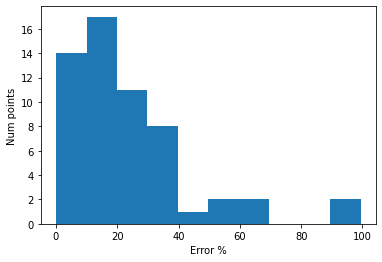

In [162]:
plt.hist(crypten_error.detach().numpy(), bins=10, density=False)  # density=False would make counts
plt.xlabel('Error %')
plt.ylabel('Num points')

In [163]:
pytorch_error = abs(pytorch_output - true_output) * 100 / (true_output)
pytorch_error_abs = abs(crypten_output - true_output)

Text(0, 0.5, 'Num points')

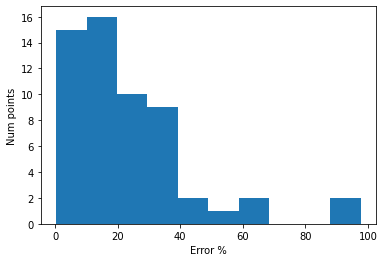

In [164]:
plt.hist(pytorch_error.detach().numpy(), bins=10, density=False)  # density=False would make counts
plt.xlabel('Error %')
plt.ylabel('Num points')

In [165]:
len(crypten_error)

57

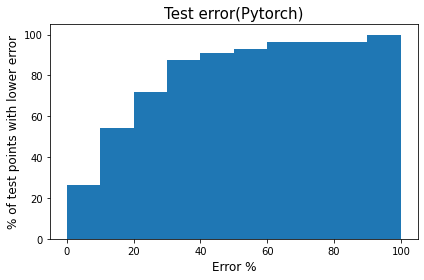

In [196]:
from scipy import stats
res = stats.cumfreq(pytorch_error.detach().numpy(), numbins=10, defaultreallimits=(0, 100))
x = 5 + np.linspace(0, 90, 10)
# fig = plt.figure(figsize=(10, 4))
# ax2 = fig.add_subplot(1, 2, 2)
plt.bar(x, res.cumcount * 100 / (len(true_output)), width=res.binsize)
# ax2.set_xlim([0, 100])
plt.title("Test error(Pytorch)", fontsize=titleFontSize)
plt.xlabel(xLabel, fontsize=labelFontSize)
plt.ylabel(yLabel, fontsize=labelFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.savefig("pytorch_error.svg")

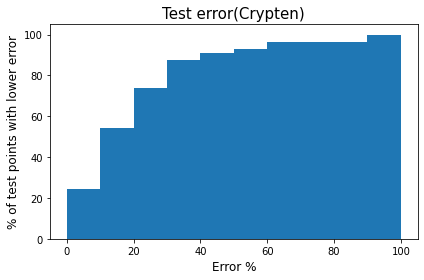

In [198]:
res = stats.cumfreq(crypten_error.detach().numpy(), numbins=10, defaultreallimits=(0, 100))
x = 5 + np.linspace(0, 90, 10)
# fig = plt.figure(figsize=(10, 4))
# ax2 = fig.add_subplot(1, 2, 2)
plt.bar(x, res.cumcount * 100 / (len(true_output)), width=res.binsize)
plt.title("Test error(Crypten)", fontsize=titleFontSize)
plt.xlabel(xLabel, fontsize=labelFontSize)
plt.ylabel(yLabel, fontsize=labelFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.savefig("crypten_error.svg")

In [197]:
res.cumcount * 100 / (len(true_output))

array([ 26.31578947,  54.38596491,  71.92982456,  87.71929825,
        91.22807018,  92.98245614,  96.49122807,  96.49122807,
        96.49122807, 100.        ])

In [199]:
res.cumcount * 100 / (len(true_output))

array([ 24.56140351,  54.38596491,  73.68421053,  87.71929825,
        91.22807018,  92.98245614,  96.49122807,  96.49122807,
        96.49122807, 100.        ])

In [281]:
np.linspace(0, 90, 10)

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [319]:
res

CumfreqResult(cumcount=array([ 9., 27., 38., 49., 52., 56., 56., 56., 56., 57.]), lowerlimit=0, binsize=10.0, extrapoints=0)

In [308]:
res

0.8596491228070176

In [42]:
len(true_output)

10

In [348]:
crypten_error[0:68-11].shape

torch.Size([57])